In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
from PIL import Image
import boto3 
from glob import glob
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import fbeta_score
import _pickle as cPickle
from sklearn.svm import LinearSVC
import warnings
warnings.simplefilter('ignore')

from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.callbacks import ModelCheckpoint, TensorBoard
import h5py

Using TensorFlow backend.


## Configuring AWS S3

In [3]:
s3_clinet = boto3.client("s3")
s3_resource = boto3.resource('s3')
bucket = 'amazon-deforesation'
result = s3_clinet.list_objects(Bucket=bucket, Delimiter='/')['CommonPrefixes']
image_folders = []
for item in result:
    image_folders.append(item.get('Prefix').split('/')[0])
print("Images : ",image_folders)

csv_files = glob('./data/*')
print("CSV files: ",csv_files)

#assuming that test-tif-v3 is similar to test-tif-v2

Images :  ['test-jpg-additional', 'test-jpg', 'test-tif-v2', 'train-jpg', 'train-tif-v2']
CSV files:  ['./data/sample_submission_v2.csv', './data/test_v2_file_mapping.csv', './data/train_v2.csv']


In [4]:
df_train = pd.read_csv('./data/train_v2.csv')
df_train.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [5]:
tags = df_train['tags'].apply(lambda x: x.split(' '))
tags_count = {}
tag_tracker = {}
count = 0
for tag_group in tags:
    for tag in tag_group:
        if tag not in tag_tracker:
            tag_tracker[tag] = count
            tags_count[count] = {}
            tags_count[count]['tag'] = tag
            tags_count[count]['count'] = 1
            count +=1
        else:
            _index = tag_tracker[tag]
            tags_count[_index]['count'] += 1

print("Tags: ",tags_count)
print("Number of tags:", len(tags_count))
print("Number of Images in train folder:",len(df_train['image_name']))

Tags:  {0: {'tag': 'haze', 'count': 2697}, 1: {'tag': 'primary', 'count': 37513}, 2: {'tag': 'agriculture', 'count': 12315}, 3: {'tag': 'clear', 'count': 28431}, 4: {'tag': 'water', 'count': 7411}, 5: {'tag': 'habitation', 'count': 3660}, 6: {'tag': 'road', 'count': 8071}, 7: {'tag': 'cultivation', 'count': 4547}, 8: {'tag': 'slash_burn', 'count': 209}, 9: {'tag': 'cloudy', 'count': 2089}, 10: {'tag': 'partly_cloudy', 'count': 7261}, 11: {'tag': 'conventional_mine', 'count': 100}, 12: {'tag': 'bare_ground', 'count': 862}, 13: {'tag': 'artisinal_mine', 'count': 339}, 14: {'tag': 'blooming', 'count': 332}, 15: {'tag': 'selective_logging', 'count': 340}, 16: {'tag': 'blow_down', 'count': 101}}
Number of tags: 17
Number of Images in train folder: 40479


## Tags Distributions

In [6]:
tags_df = pd.DataFrame.from_dict(tags_count, orient='index')
tags_df.sort_values(by=['count'], inplace=True)
tags_df

,tag,count
11,conventional_mine,100
16,blow_down,101
8,slash_burn,209
14,blooming,332
13,artisinal_mine,339
15,selective_logging,340
12,bare_ground,862
9,cloudy,2089
0,haze,2697
5,habitation,3660


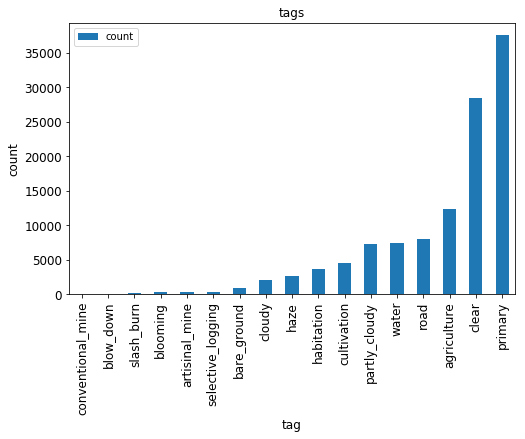

In [7]:
ax = tags_df[['tag','count']].plot(kind='bar', title ="tags", figsize=(8, 5), legend=True, fontsize=12)
ax.set_xlabel("tag", fontsize=12)
ax.set_ylabel("count", fontsize=12)
ax.set_xticklabels(tags_df['tag'])
plt.show()

## Images

In [8]:
def read_image_from_s3(key):
    obj = s3_resource.Object(bucket, key)
    img = obj.get()['Body'].read()
    image = Image.open(io.BytesIO(img))
    return image

In [8]:
from skimage.feature import hog
def get_hog_features(image, visualise=False):
    features, hog_image = hog(image, transform_sqrt=True, visualise=visualise, feature_vector=True,
                              pixels_per_cell=(25,25), cells_per_block=(10,10) )
    return features, hog_image

### get some sample images

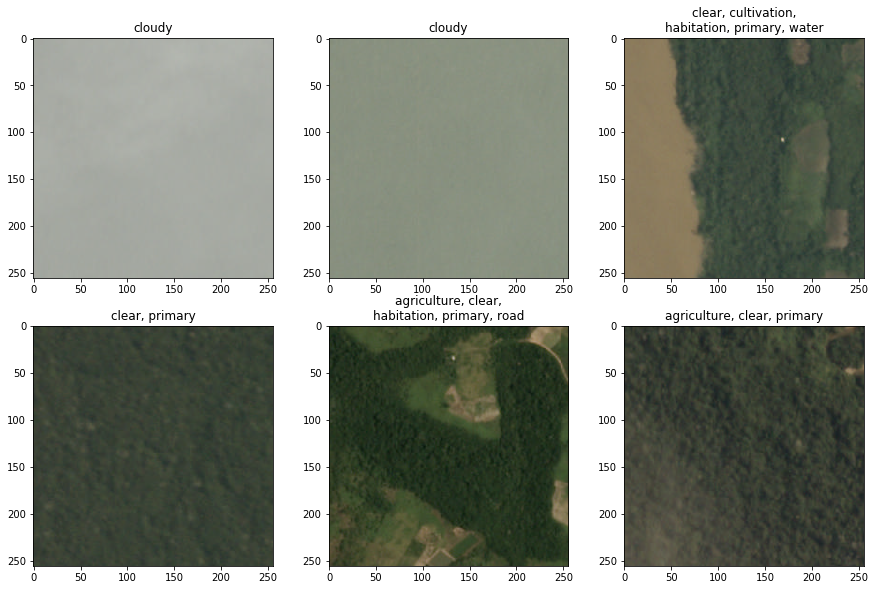

In [9]:
from textwrap import wrap
import cv2
plt.figure(figsize=(15,15))
random_samples = df_train.sample(n=6)
i = 0
for index, row in random_samples.iterrows():
    image_tags = row['tags'].replace(' ', ', ')
    title = "\n".join(wrap(image_tags, 30))
    plt.subplot(3,3,i+1)
    image_path = 'train-jpg/{}.jpg'.format(row['image_name'])
    image = read_image_from_s3(image_path)
    plt.imshow(image)
    plt.title(title,y=1)
    i+=1

## Explore hog features

/home/ec2-user/miniconda3/envs/dl-env/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


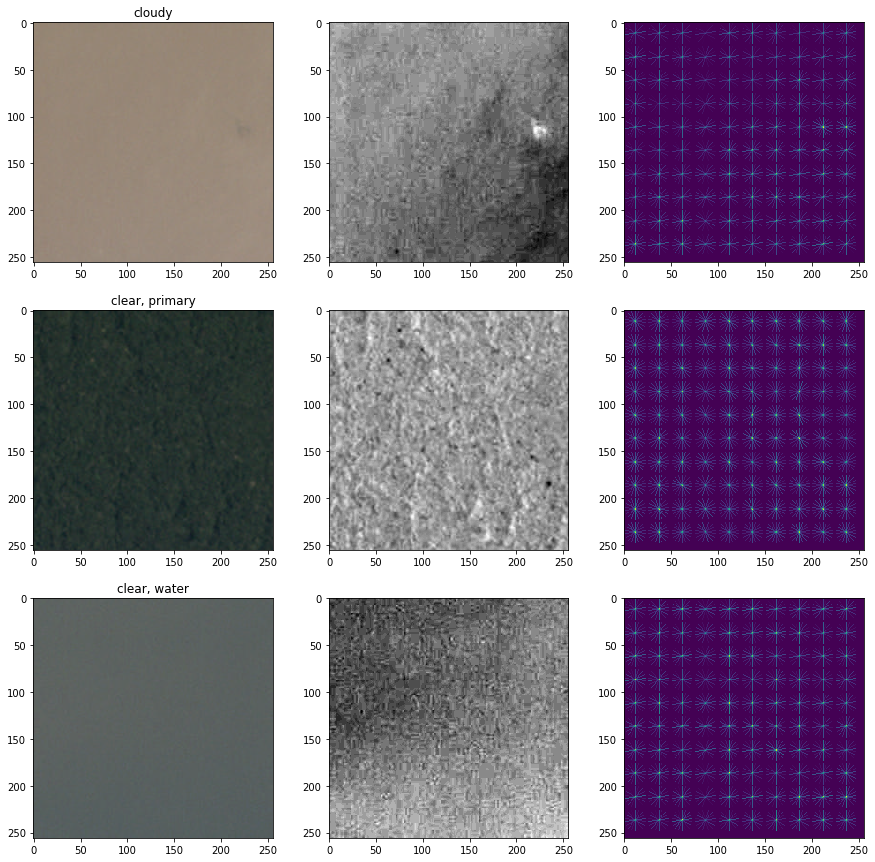

In [10]:
plt.figure(figsize=(15,15))
random_samples = df_train.sample(n=3)
i = 0
for index, row in random_samples.iterrows():
    image_tags = row['tags'].replace(' ', ', ')
    title = "\n".join(wrap(image_tags, 30))
    plt.subplot(3,3,i+1)
    image_path = 'train-jpg/{}.jpg'.format(row['image_name'])
    image = read_image_from_s3(image_path)
    plt.imshow(image)
    plt.title(title,y=1)
    image = np.array((image))
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    plt.subplot(3,3, i+2)
    plt.imshow(gray_image, cmap='gray')
    featurs, img = get_hog_features(gray_image, visualise=True)
    plt.subplot(3,3, i+3)
    plt.imshow(img)
    i+=3

## Explore different colorspaces

<Figure size 180x180 with 0 Axes>

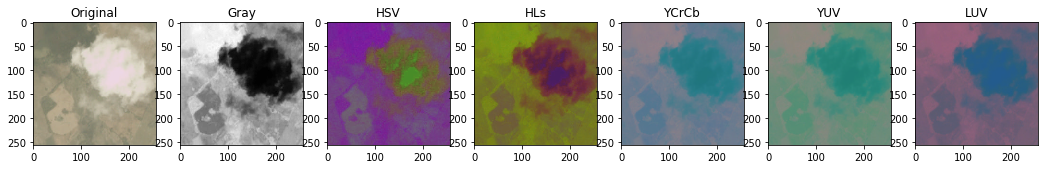

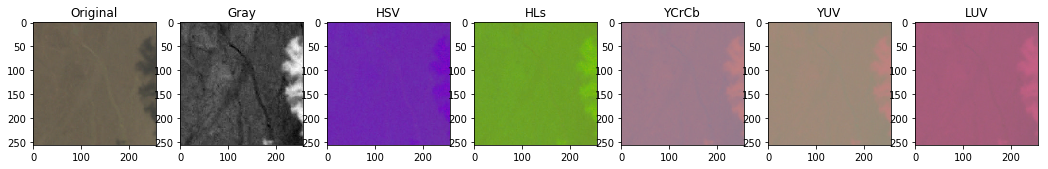

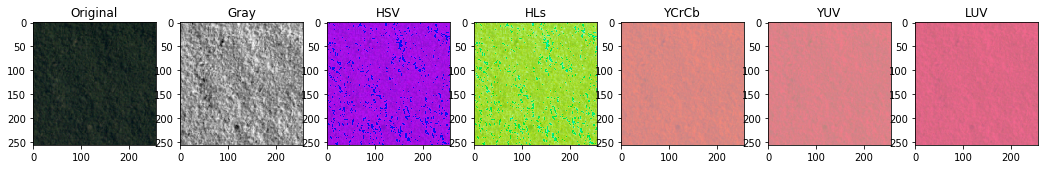

In [11]:
random_samples = df_train.sample(n=3)

def multiple_colorspaces(image):
    plt.figure(figsize=(18,18))
    
    plt.subplot(3,7,1)
    plt.title('Original')
    plt.imshow(image)
    
    image = np.array((image))
    
    gray_colorspace = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    plt.subplot(3,7,2)
    plt.title('Gray')
    plt.imshow(gray_colorspace, cmap='gray')
    
    hsv_colorspace = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    plt.subplot(3,7,3)
    plt.title('HSV')
    plt.imshow(hsv_colorspace)

    hls_colorspace = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    plt.subplot(3,7,4)
    plt.title('HLs')
    plt.imshow(hls_colorspace)

    ycrcb_colorspace = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    plt.subplot(3,7,5)
    plt.title('YCrCb')
    plt.imshow(ycrcb_colorspace)

    yuv_colorspace = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    plt.subplot(3,7,6)
    plt.title('YUV')
    plt.imshow(yuv_colorspace)

    luv_colorspace = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
    plt.subplot(3,7, 7)
    plt.title('LUV')
    plt.imshow(luv_colorspace)

plt.figure(figsize=(2.5,2.5))
for index, row in random_samples.iterrows(): 
    image_path = 'train-jpg/{}.jpg'.format(row['image_name'])
    image = read_image_from_s3(image_path)
    multiple_colorspaces(image)


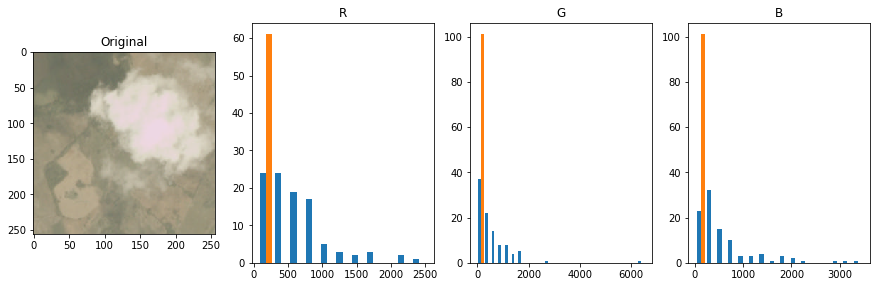

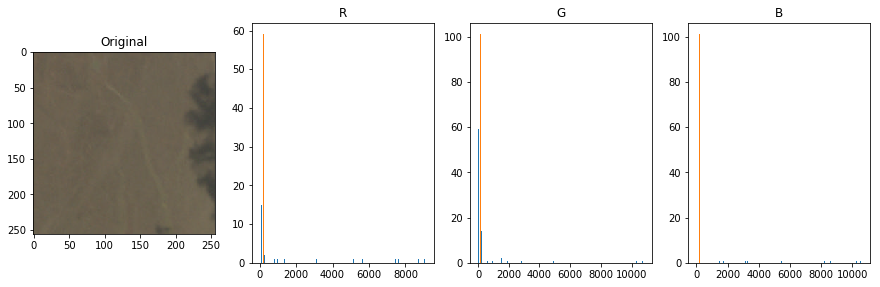

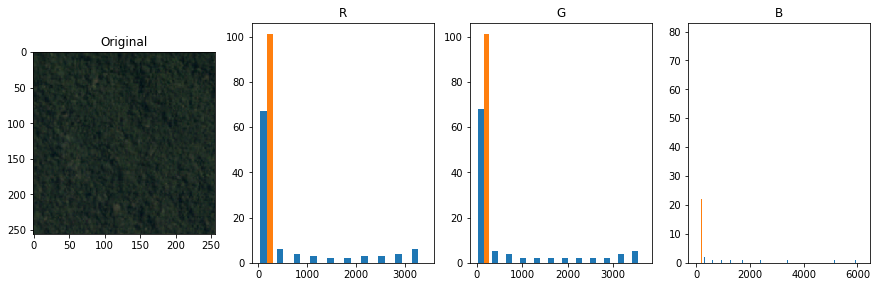

In [12]:
def color_hist(image, nbins=100):
    img = np.array((image))
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    
    plt.figure(figsize=(15,15))
    
    plt.subplot(3,4,1)
    plt.title('Original')
    plt.imshow(image)

    plt.subplot(3,4,2)
    plt.title('R')
    plt.hist(channel1_hist, bins='auto')
    
    plt.subplot(3,4,3)
    plt.title('G')
    plt.hist(channel2_hist, bins='auto')
    
    plt.subplot(3,4,4)
    plt.title('B')
    plt.hist(channel3_hist, bins='auto')

for index, row in random_samples.iterrows(): 
    image_path = 'train-jpg/{}.jpg'.format(row['image_name'])
    image = read_image_from_s3(image_path)
    color_hist(image)

## Apply Different Color maps

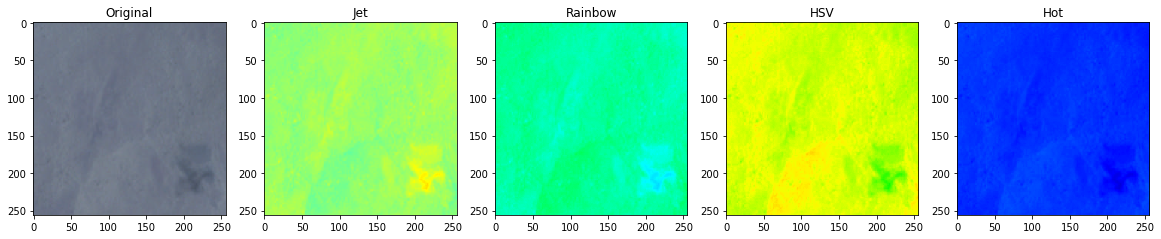

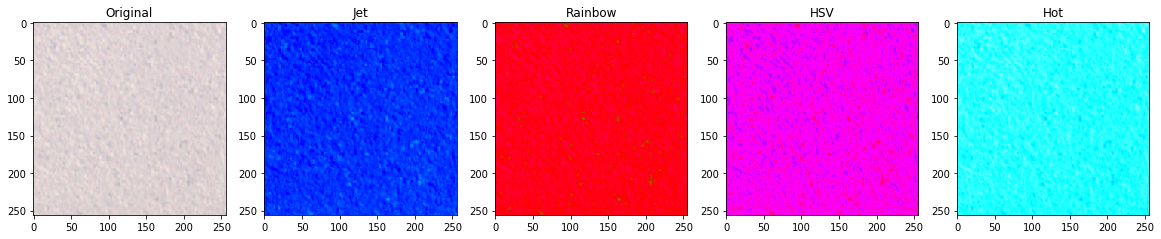

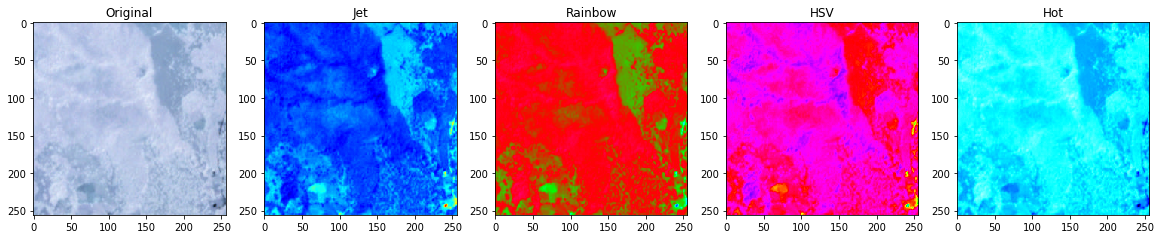

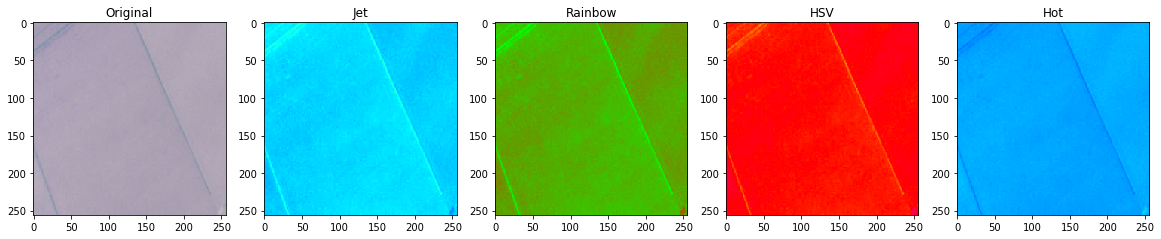

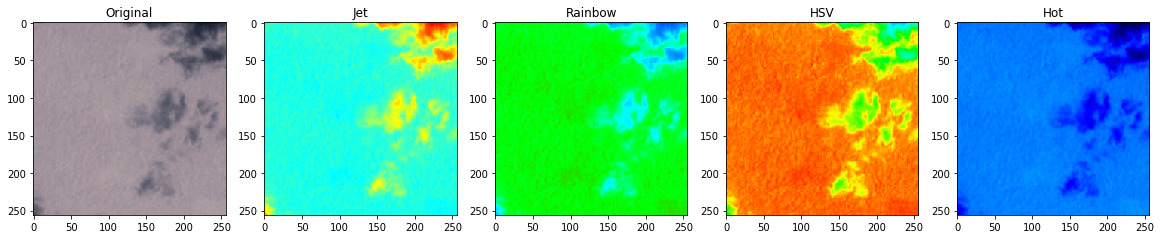

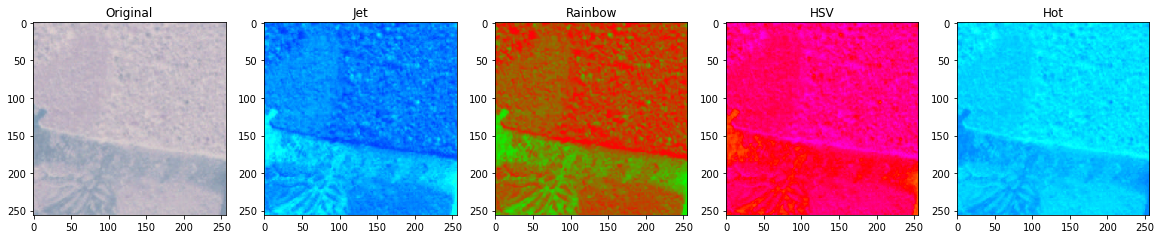

In [28]:
def color_maps(image, nbins=100):
    img = np.array((image))[:,:,:3]
    
    
    plt.figure(figsize=(20,20))
    
    img_1 = cv2.applyColorMap(img, cv2.COLORMAP_AUTUMN)
    plt.subplot(1,5,1)
    plt.title('Original')
    plt.imshow(img)
    
    
    img_3 = cv2.applyColorMap(img, cv2.COLORMAP_JET)
    plt.subplot(1,5,2)
    plt.title('Jet')
    plt.imshow(img_3)
    
    
    img_5 = cv2.applyColorMap(img, cv2.COLORMAP_RAINBOW)
    plt.subplot(1,5,3)
    plt.title('Rainbow')
    plt.imshow(img_5)
    
    img_7 = cv2.applyColorMap(img, cv2.COLORMAP_HSV)
    plt.subplot(1,5,4)
    plt.title('HSV')
    plt.imshow(img_7)
    
    img_8 = cv2.applyColorMap(img, cv2.COLORMAP_HOT)
    plt.subplot(1,5,5)
    plt.title('Hot')
    plt.imshow(img_8)
    
 
random_samples = df_train.sample(6)
for index, row in random_samples.iterrows():
    image_path = 'train-jpg/{}.jpg'.format(row['image_name'])
    image = read_image_from_s3(image_path)
    color_maps(image)

## Data

In [13]:
dataset_size = 5000

image_paths = df_train.as_matrix(columns=['image_name'])
y = df_train['tags'].map(lambda item: item.split(" "))[:dataset_size]
print('-----------------------------------------')
print('Labels:')
print('-----------------------------------------')
print(y[:5].to_csv(sep='\t', index=False))

# converting multilables to binarized labels
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y)

print('\n-----------------------------------------')
print('Binarized Labels:')
print('-----------------------------------------')
print(y[:5])

X = None
_resize = 64

for item in df_train['image_name'][:dataset_size]:
    image_path = 'train-jpg/{}.jpg'.format(item)
    image = read_image_from_s3(image_path)
    image = np.array((image))
    _image = cv2.resize(image[:,:,0:3], (_resize,_resize)).ravel()
    if X is None:
        X = np.copy(_image)
    else:
        X = np.vstack((X, _image))
X = np.squeeze(X)  
print(X.shape)

-----------------------------------------
Labels:
-----------------------------------------
['haze', 'primary']
['agriculture', 'clear', 'primary', 'water']
['clear', 'primary']
['clear', 'primary']
['agriculture', 'clear', 'habitation', 'primary', 'road']


-----------------------------------------
Binarized Labels:
-----------------------------------------
[[0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1]
 [0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0]]
(5000, 12288)


## Train/Validation Split

In [14]:
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train Data => X size:{}, Y size:{}".format(X_train_svm.shape, y_train_svm.shape))
print("Test Data => X size:{}, Y size:{}".format(X_test_svm.shape, y_test_svm.shape))

Train Data => X size:(4000, 12288), Y size:(4000, 17)
Test Data => X size:(1000, 12288), Y size:(1000, 17)


# Benchmark 1 : SVM on 5000 input

In [16]:
from sklearn.svm import LinearSVC

base_clf = LinearSVC(verbose=True)
multi_clf = OneVsRestClassifier(base_clf, n_jobs=2).fit(X_train_svm, y_train_svm)
with open('svm_base.pkl', 'wb') as model_file:
    cPickle.dump(multi_clf, model_file)    

Basic MultiLabel SVM Model sumamry:
---
Base Classifier: LinearSVC

MultiClassifier: OneVsRestClassifier

## f2score

In [86]:

y_hat_svm = multi_clf.predict(X_test_svm)
score = fbeta_score(y_test_svm, y_hat_svm, beta=2, average=None)
avg_sample_score = fbeta_score(y_test_svm, y_hat_svm, beta=2, average='samples')
print('Average F2 test score {}'.format(avg_sample_score))
print('-----------------------------------------')
print('f2 Scores for each label:')
print('-----------------------------------------')
for _class,_score in zip(mlb.classes_, score):
    print("{} : {}".format(_class, _score))
    

Average F2 test score 0.4593213676831011
-----------------------------------------
f2 Scores for each label:
-----------------------------------------
agriculture : 0.5786573146292584
artisinal_mine : 0.0
bare_ground : 0.04807692307692308
blooming : 0.0
blow_down : 0.0
clear : 0.07410021171489062
cloudy : 0.2564102564102564
conventional_mine : 0.0
cultivation : 0.03138075313807531
habitation : 0.1328502415458937
haze : 0.0
partly_cloudy : 0.10723860589812331
primary : 0.9536138079827398
road : 0.5084253341080767
selective_logging : 0.0
slash_burn : 0.0
water : 0.07042253521126761


### Running a few test samples 

Predicted: ['agriculture', 'clear', 'primary', 'road']
Real: ['agriculture', 'clear', 'habitation', 'primary', 'road']


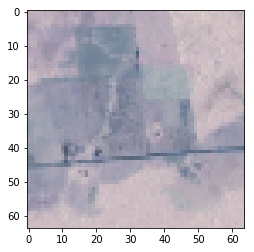

Predicted: ['cloudy', 'road']
Real: ['agriculture', 'clear', 'primary', 'water']


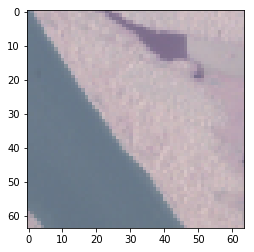

Predicted: ['agriculture', 'primary', 'road']
Real: ['clear', 'primary']


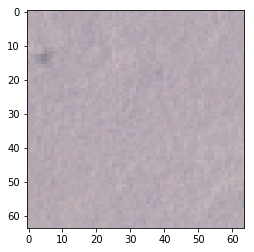

Predicted: ['agriculture', 'primary', 'road']
Real: ['agriculture', 'haze', 'primary', 'water']


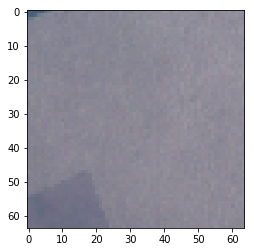

In [29]:

def test_svm_samples(sample_index):
    hat_ = np.where(y_hat_svm[sample_index] == 1)[0]
    true_ = np.where(y_test_svm[sample_index] == 1)[0]

    labels_hat = []
    labels_true = []
    for label_index in hat_:
        labels_hat.append(mlb.classes_[label_index])
    for label_index in true_:
        labels_true.append(mlb.classes_[label_index])

    test_image = np.reshape(X_test_svm[sample_index], (64,64,3))
    print("Predicted: {}".format(labels_hat))
    print("Real: {}".format(labels_true))
    plt.imshow(test_image)
    plt.show()
    
test_svm_samples(0)
test_svm_samples(10)
test_svm_samples(20)
test_svm_samples(30)

# Benchmark 2: CNN on 5000 input

In [31]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.callbacks import ModelCheckpoint, TensorBoard
import h5py

Using TensorFlow backend.


In [32]:

_resize = 64
X_cnn = np.zeros((dataset_size, _resize, _resize,3))
i = 0
for item in df_train['image_name'][:dataset_size]:
    image_path = 'train-jpg/{}.jpg'.format(item)
    image = read_image_from_s3(image_path)
    image = np.array((image))
    _image = cv2.resize(image[:,:,0:3], (_resize,_resize))/255
    X_cnn[i] = _image
    i+=1
X_cnn = np.squeeze(X_cnn)


X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(X_cnn, y, test_size=0.2, random_state=42)
print("Train Data => X size:{}, Y size:{}".format(X_train_cnn.shape, y_train_cnn.shape))
print("Test Data => X size:{}, Y size:{}".format(X_test_cnn.shape, y_test_cnn.shape))

Train Data => X size:(4000, 64, 64, 3), Y size:(4000, 17)
Test Data => X size:(1000, 64, 64, 3), Y size:(1000, 17)


Basic CNN Model sumamry:
---
Conv2D       (None, 64, 64, 10)
MaxPooling2D (None, 32, 32, 10)       
Flatten      (None, 10240)       
Dense       (None, 17)

- Total params: 174,857
- Trainable params: 174,857
- Non-trainable params: 0
------------
* Epochs: 50 iterations
* Batch Size: 32
* Optimizer: adamax
* Loss Function: categorical_crossentropy

In [33]:
model = Sequential()
model.add(Conv2D(filters=10, kernel_size=(5,5), activation='relu', padding='SAME', input_shape=(_resize, _resize, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(y.shape[1], activation='softmax'))
model.summary()

model.compile(optimizer='adamax', loss='categorical_crossentropy', metrics=['accuracy'])

ckpt = ModelCheckpoint('./checkpoint')
tb = TensorBoard(log_dir='./logs')
model.fit(X_train_cnn, y_train_cnn, epochs=50, batch_size=32, validation_split=0.2, callbacks=[ckpt, tb])
model.save('cnn_base.h5') 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 10)        760       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 10)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 10240)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 17)                174097    
Total params: 174,857
Trainable params: 174,857
Non-trainable params: 0
_________________________________________________________________
Train on 3200 samples, validate on 800 samples
Epoch 1/50
3200/3200 [==============================] - 2s 502us/step - loss: 5.6752 - acc: 0.0075 - val_loss: 5.6721 - val_acc: 0.0000e+00
Epoch 2/50
3200/3200 [==============================] - 1s 313us/step - loss: 5.5

In [ ]:
y_hat_cnn = model.predict(X_test_cnn)

### Setting a Threshold:

- Getting average confidence score
- Filtering predicted labels that are above or equal average

Example: 

Reference Labels: 
['agriculture' 'artisinal_mine' 'bare_ground' 'blooming' 'blow_down'
 'clear' 'cloudy' 'conventional_mine' 'cultivation' 'habitation' 'haze'
 'partly_cloudy' 'primary' 'road' 'selective_logging' 'slash_burn' 'water']
 
For a test sample, cnn model returns softmax predictions :
 [1.40582338e-01 3.00636661e-04 2.47537042e-03 2.10377566e-05
 1.15574505e-04 2.19808951e-01 5.01600116e-05 2.58560590e-07
 4.81739044e-02 8.43761787e-02 3.01485474e-04 1.59988366e-02
 3.36099416e-01 8.67485106e-02 1.62545487e-03 7.20588118e-03
 5.61159812e-02]

Confidence score mean : 0.05882353

Top Predictions:  ['agriculture', 'bare_ground', 'clear', 'road']

Real Labels:  ['agriculture', 'clear', 'primary', 'road']


### f2 score

In [84]:
score_cnn = fbeta_score(y_test_svm, y_hat_svm, beta=2, average=None)
avg_score_cnn = fbeta_score(y_test_cnn, np.array(y_hat_cnn) > 0.2, beta=2, average='samples')

print("Average F2 score: {}".format(avg_score_cnn))
print('\n-----------------------------------------')
print('F2 score for each class:')
print('-----------------------------------------')

for _class,_score in zip(mlb.classes_, score_cnn):
    print("{} : {}".format(_class, _score))

Average F2 score: 0.6655375717266685

-----------------------------------------
F2 score for each class:
-----------------------------------------
agriculture : 0.5786573146292584
artisinal_mine : 0.0
bare_ground : 0.04807692307692308
blooming : 0.0
blow_down : 0.0
clear : 0.07410021171489062
cloudy : 0.2564102564102564
conventional_mine : 0.0
cultivation : 0.03138075313807531
habitation : 0.1328502415458937
haze : 0.0
partly_cloudy : 0.10723860589812331
primary : 0.9536138079827398
road : 0.5084253341080767
selective_logging : 0.0
slash_burn : 0.0
water : 0.07042253521126761


### Running a few test samples 

Avegrage confidence score on labels:0.05882352963089943
Predicted: ['agriculture' 'clear' 'habitation' 'primary' 'road']
Real: ['agriculture' 'clear' 'habitation' 'primary' 'road']


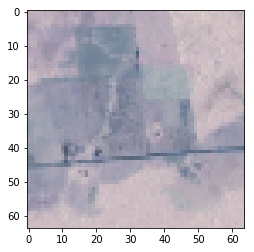

Avegrage confidence score on labels:0.058823537081480026
Predicted: ['agriculture' 'clear' 'partly_cloudy' 'primary' 'road' 'water']
Real: ['agriculture' 'clear' 'primary' 'water']


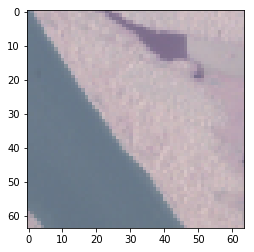

Avegrage confidence score on labels:0.05882352963089943
Predicted: ['clear' 'primary']
Real: ['clear' 'primary']


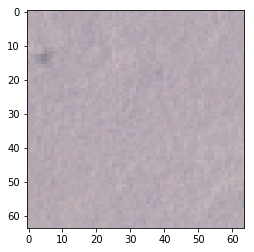

Avegrage confidence score on labels:0.05882352218031883
Predicted: ['agriculture' 'clear' 'haze' 'primary' 'road' 'water']
Real: ['agriculture' 'haze' 'primary' 'water']


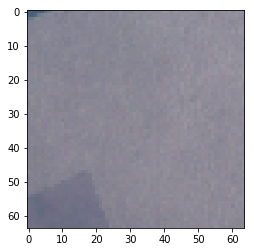

In [77]:
def test_cnn_samples(sample_index):
    # find confidences above average 
    confidence_avg = np.mean(y_hat_cnn[sample_index])
    y_hat_best_indices= np.where(y_hat_cnn[sample_index] >= confidence_avg)[0]
    y_true_indices = np.where(y_test_cnn[sample_index] == 1)[0]
    
    print("Avegrage confidence score on labels:{}".format(confidence_avg))
    labels_hat = np.array(mlb.classes_)[y_hat_best_indices] 
    labels_true = np.array(mlb.classes_)[y_true_indices] 

    test_image =X_test_cnn[sample_index]
    print("Predicted: {}".format(labels_hat))
    print("Real: {}".format(labels_true))
    plt.imshow(test_image)
    plt.show()
    
test_cnn_samples(0)
test_cnn_samples(10)
test_cnn_samples(20)
test_cnn_samples(30)

In [89]:
len(df_train)

40479

## First Model: Lenet5

[Lenet5](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf) is Convolutional Neural Network developed by Yann Lecun and his team for rcognizing handwritten and machine-printed character patterns.  
<img src="./assets/lenet5.png" width="100%" height="400"/>


In [6]:
# Lenet5 with tweaks: input size is 64x64x4 instead of 32x32x1
_resize = 64
model = Sequential()
model.add(Conv2D(filters=6, kernel_size=(5,5), activation='relu', padding='SAME', input_shape=(_resize, _resize, 4)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=16, kernel_size=(5,5), activation='relu', padding='SAME', input_shape=(_resize, _resize, 4)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(120, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(84, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(17, activation='softmax'))
model.summary()

model.compile(optimizer='adamax', loss='categorical_crossentropy', metrics=['accuracy'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 64, 64, 6)         606       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 6)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 16)        2416      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 16, 16, 16)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 120)               491640    
__________

### Model performance
I trained the model on 5000 images with split 20% : 4000 Train & 1000 Validation for 5 epochs, model has a poor performance which apparently has overfitted on labels "primary" and "clear", here is the model f2 scores summary:

* Average F2 test score: 0.45
* F2 Scores for each label:
  * agriculture : 0.0
  * artisinal_mine : 0.0
  * bare_ground : 0.0
  * blooming : 0.0
  * blow_down : 0.0
  * clear : 1.0
  * cloudy : 0.0
  * conventional_mine : 0.0
  * cultivation : 0.0
  * habitation : 0.0
  * haze : 0.0
  * partly_cloudy : 0.0
  * primary : 1.0
  * road : 0.0
  * selective_logging : 0.0
  * slash_burn : 0.0
  * water : 0.0

### Tensorboard Diagrams:

Model accuracy is dropping and loss is not reducing on the validation data which is not a good sign and this model is not doing well on deforestation dataset:

<img src="./assets/lenet5_tb.png" width="100%" height="400"/>

## Second Model: Transfer Learning VGG16

[VGG16](http://lanl.arxiv.org/pdf/1409.1556) is 16 layers Convolutional Neural Network developed by VGG team and achieved 7.5% top-5 error on ILSVRC-2012-val, 7.4% top-5 error on ILSVRC-2012-test.

<img src="./assets/VGG16-architecture-16.png" width="100%" height="50"/>


In [5]:
from keras.layers.normalization import BatchNormalization
from keras.applications.vgg16 import VGG16
from keras.models import  Model
from keras.layers import Input, Dense, Flatten
from keras.optimizers import RMSprop
_resize = 128
_learning_rate = 0.00001
input_tensor = Input(shape=(_resize,_resize,3))
model = VGG16(weights='imagenet', include_top=False, input_shape=(_resize,_resize,3))
batch_normalization = BatchNormalization()(input_tensor)
model = model(batch_normalization)
model = Flatten()(model)
output = Dense(17, activation='sigmoid')(model)
model = Model(input_tensor, output)
model.summary()
_rsmprops =  RMSprop(lr=_learning_rate, rho=0.9, epsilon=None, decay=0.0001)
model.compile(optimizer=_rsmprops, loss='categorical_crossentropy', metrics=['accuracy'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 128, 128, 3)       12        
_________________________________________________________________
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 17)                139281    
Total params: 14,853,981
Trainable params: 14,853,975
Non-trainable params: 6
_________________________________________________________________


### Model performance
I trained the model on 20,000 images with split 20% : 16,000 Train & 4000 Validation for 10 epochs, tested on 5000 images,  model accuracy is still around 50% (stopped improving after 3 epochs) and it did not manage to decrease the error loss. However model is picking new features and is able to predict more labels such as agriculture, road, water clear& primary:

* Average F2 test score 0.54
* F2 Scores for each label:
    * agriculture : 0.4339984475594721
    * artisinal_mine : 0.0
    * bare_ground : 0.0
    * blooming : 0.0
    * blow_down : 0.0
    * clear : 0.8021996473847703
    * cloudy : 0.0
    * conventional_mine : 0.0
    * cultivation : 0.0
    * habitation : 0.0
    * haze : 0.0
    * partly_cloudy : 0.0
    * primary : 0.9657898983379054
    * road : 0.2729851099030962
    * selective_logging : 0.0
    * slash_burn : 0.0
    * water : 0.27566495015826525

### Tensorboard Diagrams:

Model accuracy has stopped improving after reaching 0.35 and loss is pretty much a straight line at 3 showing that it's not learning:

<img src="./assets/vgg16_tb.png" width="100%" height="400"/>